In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences # to pad sequences

from sklearn.preprocessing import StandardScaler # to normalise data
from sklearn.metrics import mean_squared_error

2023-05-01 22:14:40.631793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 22:14:40.753129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-01 22:14:40.753149: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 22:14:41.554722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:

cwd = os.getcwd()
print(cwd)

# change working directory if needed
# DIR = "set working directory here"
# os.chdir(DIR)

/home/hv4691


In [3]:
#========================#
# LOAD DATA              #
#========================#
#
# Variable Names:
# train_data
# test_data
#

# load each fold as dictionary
def load_data_with_folds(scenario_dir_path, dataset_type):
    # make dict to store data frames for each fold
    fold_dfs = {}
    # iterate over the scenario directory
    for fold_dir in Path(scenario_dir_path).iterdir():
        if fold_dir.name.startswith('.'):
            continue  # skip hidden files/folders like .DS_Store and .ipynb_checkpoints
        train_annotations_dir = Path(fold_dir, f"{dataset_type}/annotations/")
        train_physiology_dir = Path(fold_dir, f"{dataset_type}/physiology/")
        train_physiology_files = sorted(p for p in Path(train_physiology_dir).iterdir() if not p.name.startswith('.'))
        train_annotation_files = sorted(p for p in Path(train_annotations_dir).iterdir() if not p.name.startswith('.'))
        fold_df = pd.DataFrame()
        for physiology_file_path, annotations_file_path in zip(train_physiology_files, train_annotation_files):
            if physiology_file_path.name.startswith('.') or annotations_file_path.name.startswith('.'):
                continue  # skip hidden files like .DS_Store and .ipynb_checkpoints
            assert physiology_file_path.name == annotations_file_path.name, "Order mismatch"
            df_physiology = pd.read_csv(physiology_file_path)
            df_annotations = pd.read_csv(annotations_file_path)
            subject = annotations_file_path.name
            merged_df = pd.merge(df_physiology, df_annotations, on="time", how="outer")
            merged_df["subject"] = [subject] * len(merged_df)
            fold_df = pd.concat([fold_df, merged_df], ignore_index=True)
        fold_dfs[fold_dir.name] = fold_df
    return fold_dfs

# specify scenario path
scenario_dir = "data/scenario_3"

# train data
print("Loading train data")
train_data = load_data_with_folds(scenario_dir, "train")

# test data
print("Loading test data")
test_data = load_data_with_folds(scenario_dir, "test")


Loading train data
Loading test data


In [4]:
# check data was loaded
print(sorted(train_data.keys()))
print(sorted(test_data.keys()))

for key, df in train_data.items():
    print(f"{key}:\n")
    display(df)
    print(f"The max time: {df['time'].max()}")

['fold_0', 'fold_1', 'fold_2', 'fold_3']
['fold_0', 'fold_1', 'fold_2', 'fold_3']
fold_0:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,1.280,36.873,39.288,34.405,26.785,5.440,5.563,7.124,5.000,5.000,sub_0_vid_0.csv
1,1,1.273,37.009,39.292,34.424,26.792,5.399,5.604,7.205,NaN,NaN,sub_0_vid_0.csv
2,2,1.260,37.029,39.288,34.424,26.795,5.440,5.645,7.165,NaN,NaN,sub_0_vid_0.csv
3,3,1.260,36.646,39.374,34.434,26.795,5.440,5.564,7.165,NaN,NaN,sub_0_vid_0.csv
4,4,1.260,36.757,39.320,34.396,26.785,5.277,5.441,7.124,NaN,NaN,sub_0_vid_0.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
15808275,79696,0.803,36.895,30.540,34.270,26.707,5.400,9.751,21.743,NaN,NaN,sub_8_vid_4.csv
15808276,79697,0.823,37.019,30.520,34.289,26.718,5.480,9.793,21.825,NaN,NaN,sub_8_vid_4.csv
15808277,79698,0.813,37.125,30.488,34.289,26.711,5.481,9.834,21.826,NaN,NaN,sub_8_vid_4.csv
15808278,79699,0.813,36.887,30.418,34.270,26.708,5.400,9.916,21.745,NaN,NaN,sub_8_vid_4.csv


The max time: 118550
fold_1:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,0.862,36.398,11.035,32.246,27.528,5.193,5.892,8.807,5.000,5.000,sub_0_vid_10.csv
1,1,0.849,36.477,11.024,32.218,27.514,5.072,5.851,8.767,NaN,NaN,sub_0_vid_10.csv
2,2,0.849,36.084,11.016,32.237,27.521,5.152,5.932,8.807,NaN,NaN,sub_0_vid_10.csv
3,3,0.862,36.186,11.063,32.227,27.521,5.193,5.811,8.767,NaN,NaN,sub_0_vid_10.csv
4,4,0.866,36.292,11.071,32.237,27.521,5.153,5.891,8.807,NaN,NaN,sub_0_vid_10.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
15271101,79696,0.803,36.895,30.540,34.270,26.707,5.400,9.751,21.743,NaN,NaN,sub_8_vid_4.csv
15271102,79697,0.823,37.019,30.520,34.289,26.718,5.480,9.793,21.825,NaN,NaN,sub_8_vid_4.csv
15271103,79698,0.813,37.125,30.488,34.289,26.711,5.481,9.834,21.826,NaN,NaN,sub_8_vid_4.csv
15271104,79699,0.813,36.887,30.418,34.270,26.708,5.400,9.916,21.745,NaN,NaN,sub_8_vid_4.csv


The max time: 129949
fold_2:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,1.280,36.873,39.288,34.405,26.785,5.440,5.563,7.124,5.000,5.000,sub_0_vid_0.csv
1,1,1.273,37.009,39.292,34.424,26.792,5.399,5.604,7.205,NaN,NaN,sub_0_vid_0.csv
2,2,1.260,37.029,39.288,34.424,26.795,5.440,5.645,7.165,NaN,NaN,sub_0_vid_0.csv
3,3,1.260,36.646,39.374,34.434,26.795,5.440,5.564,7.165,NaN,NaN,sub_0_vid_0.csv
4,4,1.260,36.757,39.320,34.396,26.785,5.277,5.441,7.124,NaN,NaN,sub_0_vid_0.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
17667851,79696,0.803,36.895,30.540,34.270,26.707,5.400,9.751,21.743,NaN,NaN,sub_8_vid_4.csv
17667852,79697,0.823,37.019,30.520,34.289,26.718,5.480,9.793,21.825,NaN,NaN,sub_8_vid_4.csv
17667853,79698,0.813,37.125,30.488,34.289,26.711,5.481,9.834,21.826,NaN,NaN,sub_8_vid_4.csv
17667854,79699,0.813,36.887,30.418,34.270,26.708,5.400,9.916,21.745,NaN,NaN,sub_8_vid_4.csv


The max time: 129949
fold_3:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,1.280,36.873,39.288,34.405,26.785,5.440,5.563,7.124,5.0,5.000,sub_0_vid_0.csv
1,1,1.273,37.009,39.292,34.424,26.792,5.399,5.604,7.205,NaN,NaN,sub_0_vid_0.csv
2,2,1.260,37.029,39.288,34.424,26.795,5.440,5.645,7.165,NaN,NaN,sub_0_vid_0.csv
3,3,1.260,36.646,39.374,34.434,26.795,5.440,5.564,7.165,NaN,NaN,sub_0_vid_0.csv
4,4,1.260,36.757,39.320,34.396,26.785,5.277,5.441,7.124,NaN,NaN,sub_0_vid_0.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
17275001,106046,0.787,37.765,18.345,34.850,26.182,5.645,6.138,18.670,NaN,NaN,sub_8_vid_3.csv
17275002,106047,0.787,37.766,18.384,34.802,26.182,5.523,6.098,18.176,NaN,NaN,sub_8_vid_3.csv
17275003,106048,0.774,37.919,18.420,34.792,26.178,5.685,6.138,17.561,NaN,NaN,sub_8_vid_3.csv
17275004,106049,0.767,38.016,18.455,34.792,26.178,5.605,6.138,17.067,NaN,NaN,sub_8_vid_3.csv


The max time: 129949


In [13]:
#====================================#
# PAD VIDEO SEQUENCES: TRAINING SET  #
#====================================#
#
# Variable Names:
# train_data_scaled_padded
# test_data_scaled_padded
#

# set maxlen so that it is in increments of 50 to match the affect timescales
maxlen = 132000 

# separate out each video sequence, in prep for padding
train_data_scaled_padded = {}

# loop through each fold
for key, df in train_data.items():
    
    # find start of each sequence
    idx_zero = np.where(df['time']==0)[0]

    # initialize lists to store the data
    valence = []
    arousal = []
    raw_data = []

    # loop through each video sequence in the fold
    for i in range(len(idx_zero)):
        
        if i == len(idx_zero) - 1:
            
            valence.append(df['valence'][idx_zero[i]:])
            arousal.append(df['arousal'][idx_zero[i]:])
            raw_data.append(df.iloc[idx_zero[i]:, 1:9])
            
        else:
            
            valence.append(df['valence'][idx_zero[i]:idx_zero[i+1]])
            arousal.append(df['arousal'][idx_zero[i]:idx_zero[i+1]])
            raw_data.append(df.iloc[idx_zero[i]:idx_zero[i+1], 1:9])

    # store in each fold in dictionary
    train_data_scaled_padded[key] = {
        'valence': np.array(valence, dtype=object),
        'arousal': np.array(arousal, dtype=object),
        'raw_data': np.array(raw_data, dtype=object)
    }

# pad train data sequences to make them equal length
for key, array in train_data_scaled_padded.items():
    
    array['valence'] = pad_sequences(valence, dtype="float64", maxlen=maxlen, value=0.0, padding="post")
    array['arousal'] = pad_sequences(arousal, dtype="float64", maxlen=maxlen, value=0.0, padding="post")
    array['raw_data'] = pad_sequences(raw_data, dtype="float64", maxlen=maxlen, value=0.0, padding="post")

# check shape after padding
for key, array in train_data_scaled_padded.items():  
    
    print(array['valence'].shape)
    print(array['arousal'].shape)
    print(array['raw_data'].shape)
    break
    
for seq in array['valence']:
    length = len(seq)
    print(f"Length of sequence: {length}")
    break

(180, 132000)
(180, 132000)
(180, 132000, 8)
Length of sequence: 132000


In [14]:
# reshape data to prepare for timeseries batching
for key, array in train_data_scaled_padded.items():
    array['valence'] = array['valence'].reshape(-1)
    array['arousal'] = array['arousal'].reshape(-1)
    array['raw_data'] = array['raw_data'].reshape(-1, 8)
    
# check shape again
for key, array in train_data_scaled_padded.items():  
    print(array['valence'].shape)
    print(array['arousal'].shape)
    print(array['raw_data'].shape)
    break



(23760000,)
(23760000,)
(23760000, 8)


In [15]:
# stack valence and arousal & transpose
for key, array in train_data_scaled_padded.items(): 
    array['affect'] = np.vstack((array['valence'], array['arousal'])).T
    print(array['affect'].shape)

(23760000, 2)
(23760000, 2)
(23760000, 2)
(23760000, 2)


In [17]:
#================================#
# PAD VIDEO SEQUENCES: TEST SET  #
#================================#


# pad test data
test_data_scaled_padded = {}

# loop through each fold
for key, df in test_data.items():
    
    # find start of each video sequence
    idx_start = np.where(df['time']==9900)[0] # only keep buffer of 100ms prior
    idx_end = np.where(df['time']==40000)[0]

    # initialize lists to store the data
    raw_data = []

    # loop through each sequence in fold
    for i in range(len(idx_start)): # n_videos
        
        raw_data.append(df.iloc[idx_start[i]:idx_end[i], 1:9])

    # store in each fold in dictionary
    test_data_scaled_padded[key] = {
        'raw_data': np.array(raw_data, dtype=object)
    }

# pad test data sequences
for key, array in test_data_scaled_padded.items():
    array['raw_data'] = pad_sequences(raw_data, dtype="float64", maxlen=30100, value=0.0, padding="post")
    array['raw_data'] = array['raw_data'].reshape(-1, 8)

# check shape after padding
for key, array in test_data_scaled_padded.items():  
    
    print(array['raw_data'].shape)
    break



(1806000, 8)


In [19]:
#================================#
# SPLIT INTO TIMESERIES BATCHES  #
#================================#
#
# Variable Names:
# train_dataset
# test_dataset
#

# split into timeseries batches for train, test
# using keras timeseries_dataset_from_array

sequence_length = 100 # 100ms windows
sampling_rate = 1 # sampling rate within a sequence
sequence_stride = 50 # how much to shift window by
delay = sequence_length # target is N+delay

train_dataset = {}
test_dataset = {}

for key, array in train_data_scaled_padded.items():
    
    train_dataset[key] = keras.utils.timeseries_dataset_from_array(
        data=array['raw_data'],
        targets= array['affect'],
        sequence_length=sequence_length,
        sequence_stride=sequence_stride,
        sampling_rate=sampling_rate,
        batch_size=2640, # number of sequences per batch,
        shuffle=False,
        )
    
    
    
for key, array in test_data_scaled_padded.items():
    
    test_dataset[key] = keras.utils.timeseries_dataset_from_array(
        data=array['raw_data'],
        targets=None, 
        sequence_length=sequence_length,
        sequence_stride=sequence_stride,
        sampling_rate=sampling_rate,
        batch_size=610,
        shuffle=False,
        )


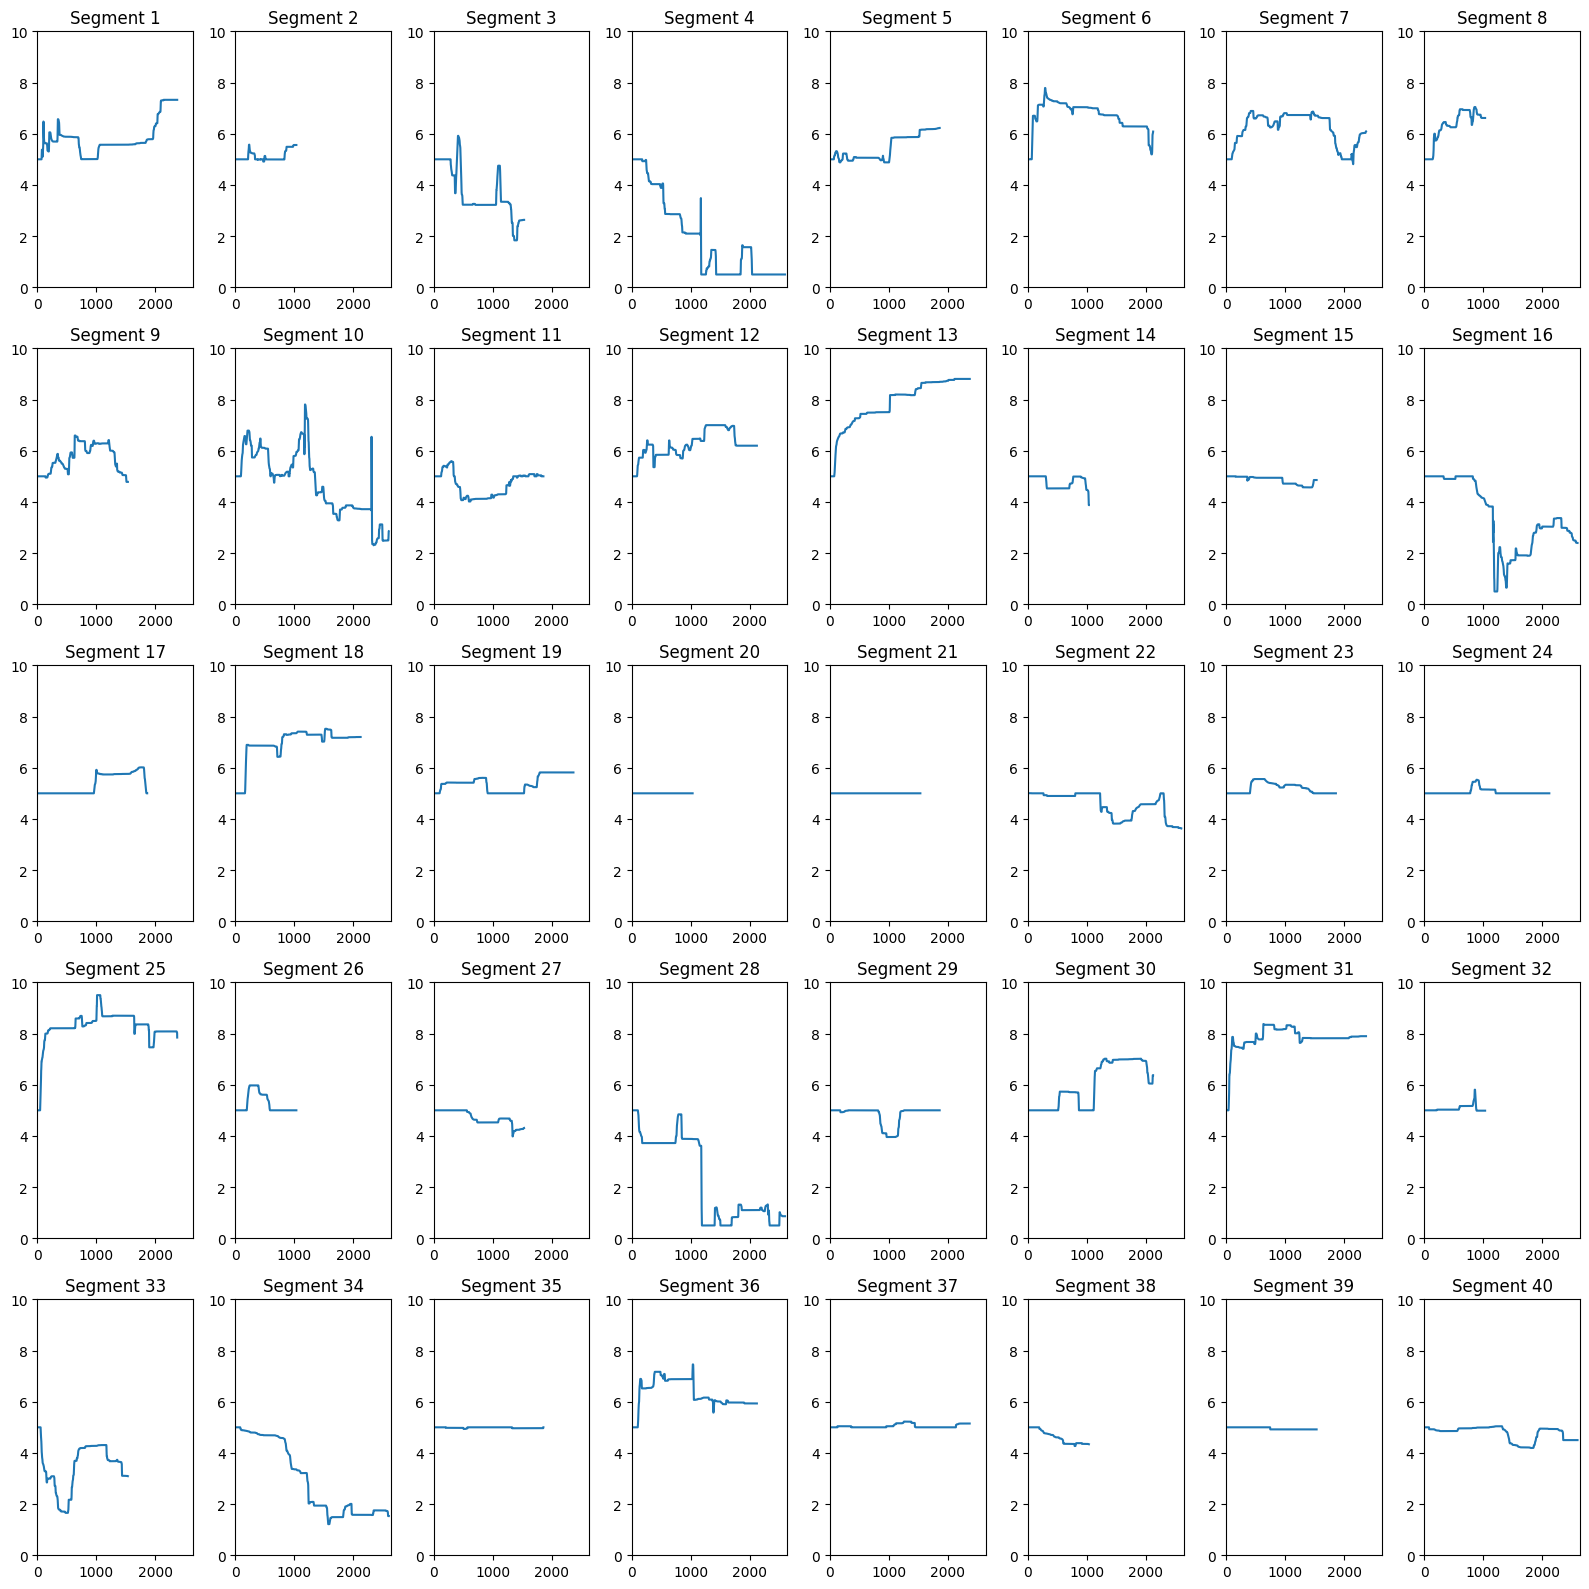

In [20]:
# check that the padded sequences are correct 
# plot valence ratings of 8 videos for first 5 subjects

import matplotlib.pyplot as plt

one_vid = maxlen

fig, axs = plt.subplots(nrows=5, ncols=8, figsize=(16, 16))

for key, array in train_data_scaled_padded.items():
    for i in range(40):
        row = i // 8
        col = i % 8
        start_idx = i * one_vid
        end_idx = (i + 1) * one_vid
        # filter out 0 values
        valence_data = array['valence'][start_idx:end_idx:50]
        valence_data = valence_data[valence_data != 0]
        axs[row, col].plot(valence_data)
        axs[row, col].set_title(f'Segment {i+1}')
        axs[row, col].set_ylim([0, 10])
        axs[row, col].set_xlim([0, maxlen/50])

    plt.tight_layout()
    plt.show()
    break

In [ ]:
#========================#
# MODEL TRAINING: LSTM   #
#========================#

# for reproducibility
tf.random.set_seed(1)

# train one model per fold
for key in sorted(train_dataset.keys()):
    print(f"Training fold: {key}")
    
    # build model
    inputs = keras.Input(shape=(100, 8))
    x = layers.Masking(mask_value=0., input_shape=(100, 8))(inputs)
    x = layers.LSTM(128, recurrent_dropout=0.25)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(2, activation="linear")(x)
    model = keras.Model(inputs, outputs)
    
    model_name = f"scen3_model_{key}.h5"
    print(f"Training model: {model_name}")
    
    # compile
    model.compile(optimizer="rmsprop",
                  loss="mse")
    
    # train
    model.fit(train_dataset[key],
              epochs=10,
              shuffle=False,
              verbose=1,
             )
    
    # save
    model.save(model_name)
    
    # reset for next fold
    model.reset_states()
    tf.keras.backend.clear_session()
    

Training fold: fold_0
Training model: scen3_model_fold_0.h5
Epoch 1/10
180/180 [==============================] - 161s 882ms/step - loss: 9.9178
Epoch 2/10
180/180 [==============================] - 159s 884ms/step - loss: 3.0485
Epoch 3/10
180/180 [==============================] - 158s 878ms/step - loss: 2.9152
Epoch 4/10
180/180 [==============================] - 157s 872ms/step - loss: 2.8954
Epoch 5/10
180/180 [==============================] - 157s 869ms/step - loss: 2.8791
Epoch 6/10
180/180 [==============================] - 154s 854ms/step - loss: 2.8731
Epoch 7/10
180/180 [==============================] - 156s 867ms/step - loss: 2.8602
Epoch 8/10
180/180 [==============================] - 157s 870ms/step - loss: 2.8506
Epoch 9/10
180/180 [==============================] - 157s 870ms/step - loss: 2.8543
Epoch 10/10
180/180 [==============================] - 155s 863ms/step - loss: 2.8499
Training fold: fold_1
Training model: scen3_model_fold_1.h5
Epoch 1/10
171/180 [=========

In [ ]:
# Define a dictionary to store predictions
all_preds = {}

# Loop through each model
for i in range(5):
    # Load the model
    model = keras.models.load_model(f'full_model_fold_{i}.h5')
    # Get predictions for the test data using the loaded model
    preds = model.predict(test_dataset[f'fold_{i}'])
    # Add the predictions to the dictionary with the key 'fold_i'
    all_preds[f'fold_{i}'] = preds
    



In [1]:
# generate and save predictions as csv files

num_iterations = 60 # 60 test files
num_preds = 601 # number of predictions per file

# loop through each fold
for key, preds in sorted(all_preds.items()):
    print(key)
    print(len(preds))
    
    # save predictions
    valence = all_preds[key][:, 0:1]
    arousal = all_preds[key][:, 1:2]
    print(len(valence))
    
    # set directory file path
    directory = f"results/scenario_3/{key}/test/annotations/"
    
    # create directory if not exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # loop through each test file and save
    for i in range(num_iterations):
        
        print(i)
        # get file name and set file path
        f = test_data[key][test_data[key]['time'] == 10000]['subject'].iloc[i]
        file_name = f"{f}"
        file_path = os.path.join(directory, file_name)
        
        # create time column
        df = pd.DataFrame({'time': np.arange(10000, 40000+1, 50)})
        
        start_index = (num_preds)*i
        end_index = (num_preds)*(i+1)
        
        # add in predictions
        df['valence'] = valence[start_index:end_index]
        df['arousal'] = arousal[start_index:end_index]
        
        display(df)
        
        # save df as csv
        df.to_csv(file_path, index=False)
        print(f"Saved: {file_path}")
    


    